In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from pylab import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cobra
import cameo
from equilibrator_api import ComponentContribution, Q_
cc = ComponentContribution()

%matplotlib inline

# Thermodynamics Constrains Information Flow in Metabolic Networks

In this notebook, the relationship between metabolic thermodynamics and information flow is explored via application of linear noise approximation (LNA). It yields the figures in the corresponding manuscript and more. It is organized as follows:

### A. Application of LNA to a toy model of a metabolic reaction
The enzyme-catalyzed, reversible conversion of substrate, $S$, to product, $P$, is considered with varied thermodynamic parameter, $K_{eq}$. LNA is applied to an exhaustive range of steady-states to determine the mutual information between $S$ and $P$, $I(S;P)$, as a function of the affinity, $\mathcal{A}$, of the reaction.

### B. Expansion of the LNA framework to include regulatory interactions
The system is augmented to include a regulatory interaction in which $S$ also binds reversibly to a regulated protein, $E_R$, and the LNA framework is expanded to capture this interaction. Parameters are varied to show that the mutual information between $S$ and $E_R$, $I(S;E)$, is high for reactions operating far from equilibrium, where $I(S;P)$ is low.

### C. Genome-wide structural analysis
Publicly-available mult-omics data are used to examine the relationship between real thermodynamic parameters and the presence of regulators. The hypothesis that substrates of reactions with small $K_{eq}$ are good regulators, as predicted by our model, is tested. 

## A. Application of LNA to a toy model of a metabolic reaction

Application of LNA involves solving the fluctuation-dissipation balance:

\begin{equation}
    \mathbf{AC} + \mathbf{CA^T} + \Omega \mathbf{BB^T} = \mathbf{0}
\end{equation}

For a system described by the vector equation:

\begin{equation}
    \mathbf{\dot{x}} = \mathbf{S} \cdot \mathbf{f}(\mathbf{x})
\end{equation}

where where $\mathbf{S}$ is the stoichiometric matrix, $\mathbf{f(x)}$ is the vector of rate equations, $\mathbf{A}$ is the Jacobian matrix evaluated at a given steady-state, $\mathbf{\bar{x}}$, and $\Omega$ is the system size. $\mathbf{BB^T}$ is the drift matrix, given by:

\begin{equation}
    \mathbf{BB^T} = \mathbf{S} \cdot \text{diag}(\mathbf{f}(\mathbf{\bar{x}})) \cdot \mathbf{S^T}
\end{equation}

where $\text{diag}(\mathbf{f}(\mathbf{\bar{x}}))$ is the matrix with diagonal elements equal to the entries of $\mathbf{f}(\mathbf{x})$ evaluated at $\mathbf{\bar{x}}$ and zero for all other elements.

The goal is to find $\mathbf{C}$ for various parameter values. As written, the fluctuation-dissipation balance is not easy to solve numberically for $\mathbf{C}$, so it is reformulated as:

\begin{equation}
    \mathbf{A'}\cdot \mathbf{C'} = -\Omega \mathbf{BB^{T'}}
\end{equation}

where $\mathbf{C'} = [C_{SS} \,\, C_{SP} \, \ldots \, C_{PP} \, \ldots \, C_{E^*E^*}]^T$ and $\mathbf{BB^{T'}} = [BB^T_{11} \,\, BB^T_{12} \, \ldots \, BB^T_{22} \, \ldots \, BB^T_{33}]^T$, i.e., vectors with entries corresponding to the serial entries of $\mathbf{C}$ and $\mathbf{BB^T}$. In this recasting, $\mathbf{A'}$ is a matrix with values derived from linear combinations of the entries of $\mathbf{A}$. Please see the Supplemental Material of the paper for more details.

In the following cells, the system and functions for determining the relevant matrices for solving the fluctuation-dissipation balance are explicitly defined based on the kinetics of the system.

### A.1 System definition
For the reversible, enzyme-catalyzed conversion of $S$ to $P$ with constant influx, $u$, there are two relevant mass balances:

\begin{equation}
    \frac{dS}{dt} = u - k^+E \frac{S/K_S}{1+S/K_S+P/K_P}\left(1-\frac{P/S}{K_{eq}}\right)
\end{equation}

\begin{equation}
    \frac{dP}{dt} = k^+E \frac{S/K_S}{1+S/K_S+P/K_P}\left(1-\frac{P/S}{K_{eq}}\right) - k_0P
\end{equation}

With

\begin{equation}
    K_{eq} = \frac{k^+/K_S}{k^-/K_P}
\end{equation}

and $k^+$ and $k^-$ being the turnover constants for the forward and reverse reactions, respectively, and $K_S$ and $K_P$ being the saturation constants for $S$ and $P$, respectively.

Nondimensionalization by defining $\tilde{S} = S/K_S$, $\tilde{P} = P/K_P$, and $\tilde{u} = u/(k^+E)$ yields:

\begin{equation}
    \frac{1}{k^+E}\frac{d\tilde{S}}{dt} = \tilde{u} - \frac{\tilde{S}}{1+\tilde{S}+\tilde{P}}\left(1-\frac{\tilde{P}}{\tilde{S}}\frac{k^-}{k^+}\right)
\end{equation}

\begin{equation}
    \frac{1}{k^+E}\frac{dP}{dt} = \frac{\tilde{S}}{1+\tilde{S}+\tilde{P}}\left(1-\frac{\tilde{P}}{\tilde{S}}\frac{k^-}{k^+}\right) - kP
\end{equation}

Two parameters remain following nondimensionalization: $\frac{k^-}{k^+} \equiv K \propto K_{eq}^{-1}$, and $k_0/(k^+E) \equiv k$.

This system has a single steady state, $(\bar{S}, \bar{P})$, for a given flux $\tilde{u} \in [0,1)$:

\begin{equation}
    \bar{S} = \frac{\tilde{u}}{1-\tilde{u}}\left[1-\frac{\tilde{u}}{k}\left(\tilde{u}-K\right)\right]
\end{equation}

\begin{equation}
    \bar{P} = \frac{\tilde{u}}{k}
\end{equation}

Since flux balance must be maintained, it is possible determine every possible steady state by simply varying $\tilde{u}$ from 0 to 1. Similarly, the flux balance constraint yields a drift matrix, $\mathbf{BB^T}$, which depends only on the flux through the reaction:

\begin{equation}
\mathbf{BB^T} = \begin{bmatrix}
2\tilde{u} & -\tilde{u}\\
-\tilde{u} & 2\tilde{u}
\end{bmatrix}
\end{equation}

See the paper and Supplemental Material for an explanation of other LNA-associated matrices for this system.

### A.2 System Analysis Using LNA

In the following cells, LNA is used to analyze the system defined above. 

In [2]:
os.chdir('...')

In [39]:
# Defines a function which determines steady state based on flux u and two parameters Keq and k, then determines and returns
# the affinity and the covariance vector as described above.

def system(u, Keq, k):
    
    P = u/k
    S = u/(1-u)*(1+P*(u+1/Keq))
    
    mass_act = (P/S)/Keq
        
    affinity = -np.log(mass_act)
    
    dfdS = (1+P*(1+1/Keq))/(1+S+P)**2
    dfdP = -(1/Keq+S*(1/Keq+1))/(1+S+P)**2
    
    A = np.array([[-dfdS, -dfdP],
                 [dfdS, dfdP-k]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,1],0],
                     [A[1,0], A[0,0]+A[1,1], 0, A[0,1]],
                     [A[1,0], 0, A[0,0]+A[1,1], A[0,1]],
                     [0, A[1,0], A[1,0], 2*A[1,1]]])
    
    BB_T = np.array([2*u, -u, -u, 2*u])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

### Increasing influx drives the system further from equilibrium

Affinity, $\mathcal{A}$ is given by

\begin{equation}
    \mathcal{A} = -\ln{\frac{Q}{K_{eq}} = -\ln{\frac{\tilde{P}}{\tilde{S}}\cdot K}}
\end{equation}

Note that at equilibrium $\mathcal{A} = 0$, and $\mathcal{A}$ grows as the reaction operates farther from equilibrium.

Substituting the steady state values for $\tilde{S}$ and $\tilde{P}$ yields:

\begin{equation}
    \rightarrow \mathcal{A} = -\ln{\left( \frac{1-\tilde{u}}{1+\frac{\tilde{u}^2}{k} + \frac{K}{k}\tilde{u}} \right)} - \ln K
\end{equation}

Which increases monotonically with $\tilde{u}$. Moreover,

\begin{equation}
    \lim_{\tilde{u}\to1} \mathcal{A} = \infty
\end{equation}

Affinities for each steady state must be calculated anyway, so we can visualize this.

In [40]:
# Vary the flux over the range of possible values, and K over a reasonable range of values to find the covariance vector and
# affinities for each of these conditions

fluxes = np.linspace(0,0.99,1000)
Keq = np.linspace(0.01, 100, 1000)

k = 1

data = np.zeros((1000,1000),dtype=float)
entropyS = np.zeros((1000,1000),dtype=float)
entropyP = np.zeros((1000,1000),dtype=float)
data_a = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system(fluxes[j], Keq[i], k)

        corr = C[1]/(np.sqrt(C[0]*C[-1]))

        entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
        entropyP[i][j] = 0.5*np.log(2*pi*e*C[-1])

        data[i][j] = -0.5*np.log(1-corr**2)
        data_a[i][j] = affinity

C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2200943641.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mass_act = (P/S)/Keq
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2227654839.py:21: RuntimeWarning: invalid value encountered in scalar divide
  corr = C[1]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2227654839.py:23: RuntimeWarning: divide by zero encountered in log
  entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2227654839.py:24: RuntimeWarning: divide by zero encountered in log
  entropyP[i][j] = 0.5*np.log(2*pi*e*C[-1])


Steady-state requires net forward flux, i.e. that $\mathcal{A}>0$. For some parameter choices, this yields a minimum value of the scaled flux, $\tilde{u}$. To find the minimum, we consider that steady state requires:

\begin{equation}
    \frac{\bar{P}}{\bar{S}} = \frac{1-\tilde{u}}{\tilde{u}^2+K_{eq}^{-1}\cdot \tilde{u}+k}  < K_{eq}
\end{equation}

Since $\frac{\bar{P}}{\bar{S}}$ decreases with increasing $\tilde{u}$, $\tilde{u}_{min}$ occurs when $\frac{\bar{P}}{\bar{S}} = K_{eq}$. Therefore,

\begin{equation}
    \tilde{u}_{min} = \frac{1}{K_{eq}}\left(\sqrt{1-kK_{eq}^2+K_{eq}}-1 \right)
\end{equation}

This is visualized below with respect to affinity, and in future blocks we use the above to find the lower bound on $\tilde{u}$ for our analyses.

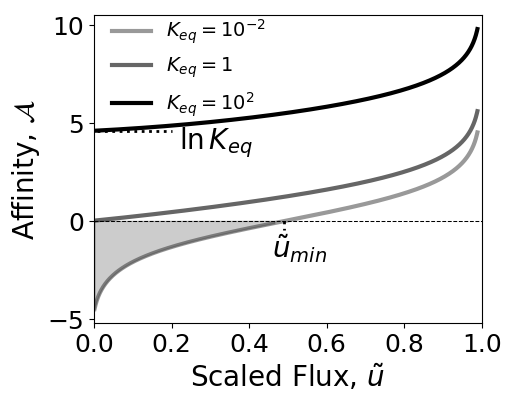

In [44]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(fluxes[1:-1], data_a[0][1:-1],color='k',alpha=0.4,linewidth=width, label = r'$K_{eq} = 10^{-2}$')
ax.plot(fluxes[1:-1], data_a[10][1:-1],color='k',alpha=0.6,linewidth=width, linestyle='-', label = r'$K_{eq}=1$')
ax.plot(fluxes[1:-1], data_a[998][1:-1],color='k',alpha=1,linewidth=width, linestyle='-',label = r'$K_{eq} = 10^2$')

ax.set_xlim(0,1)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc=(0.025,0.64), fontsize=14)

ax.plot([-0.05, 0.2], [4.6, 4.6], color='k', linestyle=':', linewidth=2)
ax.annotate(r"$\ln{K_{eq}}$", fontsize=20, xy=(0.22, 3.7))

ax.plot([0.49, 0.49], [0, -0.45], color='k', linestyle=':', linewidth=2)
ax.annotate(r"$\tilde{u}_{min}$", fontsize=20, xy=(0.46, -1.9))

plt.fill_between(
        x= fluxes[0:470],
        y1 = data_a[0][0:470],
        color= "k",
        alpha= 0.2)

ax.axhline(0, linewidth=0.75, linestyle='--',color='k')

ax.set_xlabel(r'Scaled Flux, $\tilde{u}$', fontsize=20)
ax.set_ylabel(r'Affinity, $\mathcal{A}$', fontsize=20)

plt.savefig('Affinity-flux.png',bbox_inches='tight')
plt.savefig('Affinity-flux.pdf', bbox_inches='tight')

In [32]:
def calc_system(k, n):
    
    Ks = np.logspace(-3, 3, n)

    data = np.zeros((n,n),dtype=float)
    entropyS = np.zeros((n,n),dtype=float)
    entropyP = np.zeros((n,n),dtype=float)
    data_a = np.zeros((n,n),dtype=float)

    for i in range(0,n): # For a given equilibrium constant
        
        K = Ks[i]
        
        if K < 1/k:
        
            u_min = (sqrt(1-k*K**2+K)-1)/K
        
        else:
            u_min = 0
        
        fluxes = np.linspace(u_min,0.999,n)
        
        for j in range(0,n): # Across all possible fluxes
            
            affinity, C = system(fluxes[j], K, k)
            
            corr = C[1]/(np.sqrt(C[0]*C[-1]))

            entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
            entropyP[i][j] = 0.5*np.log(2*pi*e*C[-1])

            data[i][j] = -0.5*np.log(1-corr**2)
            data_a[i][j] = affinity
    
    return entropyS, entropyP, data_a, data

In [829]:
n = 1000

Keqs = np.logspace(-3, 3, n)

In [830]:
entS = []
entP = []
datas = []
affs = []

for k in [0.01, 1, 100]:
    entropyS, entropyP, data_a, data = calc_system(k, n)
    entS.append(entropyS)
    entP.append(entropyP)
    datas.append(data)
    affs.append(data_a)

C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2200943641.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mass_act = (P/S)/Keq
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\886477381.py:27: RuntimeWarning: invalid value encountered in scalar divide
  corr = C[1]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\886477381.py:29: RuntimeWarning: divide by zero encountered in log
  entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\886477381.py:30: RuntimeWarning: divide by zero encountered in log
  entropyP[i][j] = 0.5*np.log(2*pi*e*C[-1])


Text(0, 0.5, 'Entropy, $H(x)$')

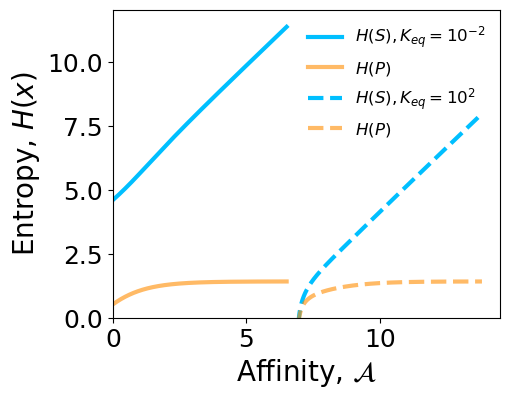

In [837]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(affs[1][0][:-1], entS[1][0][:-1],color='deepskyblue', alpha = 1, linewidth=width, label = r'$H(S), K_{eq} = 10^{-2}$')
ax.plot(affs[1][0][:-1], entP[1][0][:-1],color='darkorange', alpha = 0.6, linewidth=width, label = r'$H(P)$')

ax.plot(affs[1][999][:-1], entS[1][999][:-1],color='deepskyblue', 
        alpha = 1, linewidth=width, linestyle = '--', label = r'$H(S), K_{eq} = 10^2$')
ax.plot(affs[1][999][:-1], entP[1][999][:-1],color='darkorange', 
        alpha = 0.6, linewidth=width, linestyle='--', label = r'$H(P)$')

ax.set_xlim(0,)
ax.set_ylim(0,)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=12)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Entropy, $H(x)$', fontsize=20)


#plt.savefig('entropies.png',bbox_inches='tight')
#plt.savefig('entropies.pdf', bbox_inches='tight')

In [504]:
maxent_k01 = []
maxent_k1 = []
maxent_k100 = []

for i in range(0,n):
    maxent_k01.append(max(entS[0][i][1:]))
    maxent_k1.append(max(entS[1][i][1:]))
    maxent_k100.append(max(entS[2][i][1:]))

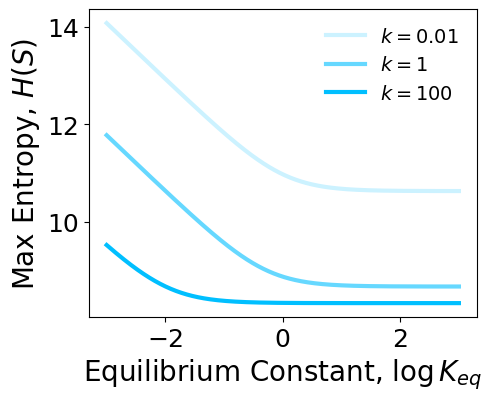

In [386]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

color = 'deepskyblue'

ax.plot(np.log10(Keqs[:]), maxent_k01,color=color, alpha = 0.2, linewidth=width, label = r'$k = 0.01$')
ax.plot(np.log10(Keqs[:]), maxent_k1,color=color, alpha = 0.6, linewidth=width, label = r'$k = 1$')
ax.plot(np.log10(Keqs[:]), maxent_k100,color=color, alpha = 1, linewidth=width, label = r'$k = 100$')

#ax.set_xlim(0,)
#ax.set_ylim(0,)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Equilibrium Constant, $\log{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Max Entropy, $H(S)$', fontsize=20)


plt.savefig('entropy-Keq.png',bbox_inches='tight')
plt.savefig('entropy-Keq.pdf', bbox_inches='tight')

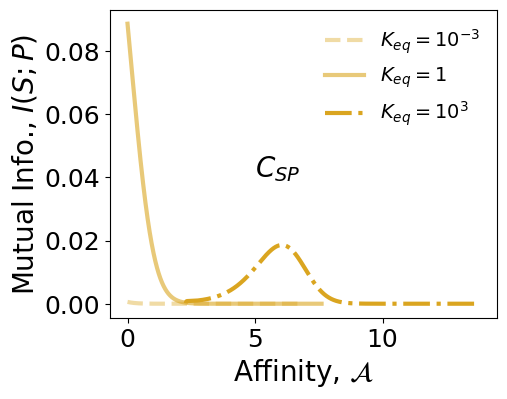

In [505]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'goldenrod'

ax.plot(affs[0][1], datas[0][1],color=color,
        alpha=0.4,linewidth=width, linestyle = '--', label = r'$K_{eq} = 10^{-3}$')
ax.plot(affs[0][500], datas[0][500],color=color,
        alpha=0.6,linewidth=width, linestyle = '-', label = r'$K_{eq} = 1$')
ax.plot(affs[0][998], datas[0][998],color=color,
        alpha=1,linewidth=width, linestyle = '-.', label = r'$K_{eq} = 10^3$')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;P)$', fontsize=20)

ax.text(5,0.04,r'$C_{SP}$',fontsize=20)

plt.savefig('Catalytic info.png',bbox_inches='tight')
plt.savefig('Catalytic info.pdf', bbox_inches='tight')

In [422]:
Csp_k01 = []
Csp_k1 = []
Csp_k100 = []

for i in range(0,n):
    Csp_k01.append(max(datas[0][i][1:]))
    Csp_k1.append(max(datas[1][i][1:]))
    Csp_k100.append(max(datas[2][i][1:]))

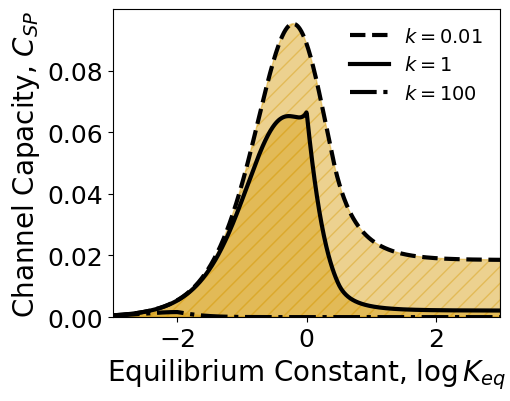

In [423]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'k'

ax.plot(np.log10(Keqs), Csp_k01,color=color,
        alpha=1,linewidth=width, linestyle = '--', label = r'$k = 0.01$')
ax.plot(np.log10(Keqs), Csp_k1,color=color,
        alpha=1,linewidth=width, linestyle = '-', label = r'$k=1$')
ax.plot(np.log10(Keqs), Csp_k100,color=color,
        alpha=1,linewidth=width, linestyle = '-.', label = r'$k=100$')


plt.fill_between(
        x= np.log10(Keqs), 
        y1= Csp_k01,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

plt.fill_between(
        x= np.log10(Keqs), 
        y1= Csp_k1,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

plt.fill_between(
        x= np.log10(Keqs), 
        y1= Csp_k100,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

ax.set_xlim(-3,3)
ax.set_ylim(0,)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Equilibrium Constant, $\log{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{SP}$', fontsize=20)

plt.savefig('Catalytic envelope.png',bbox_inches='tight')
plt.savefig('Catalytic envelope.pdf', bbox_inches='tight')

The choice of $K$ defines the range of possible affinities, because at $\tilde{u} = 0$, $\mathcal{A} = -\ln{K} \propto \ln{K_{eq}}$. The operational range of reverse-favoured reactions (those with large $K$/small $K_{eq}$) is larger than that of forward-favoured reactions (small $K$/large $K_{eq}$). Because they can operate closer to equilibrium, these reactions have much larger maixmum possible $I(S;P)$ values.

For all values of $K$,$I(S;P)$, is maximized for operation as close to equilibrium as is possible, and is asymptotic to 0 as the reaction is driven from equilibrium.

As downstream turnover increases, $C_{SP}$ declines to zero for all $K_{eq}$.

## B. Expansion of the LNA framework to include regulatory interactions
The same reaction is considered, but now the substrate, $S$, can bind a regulated enzyme, $E_R$, to form a regulated complex, $E^*$. The mutual information between $S$ and $E^*$, $I(S;E)$, for various parameter sets across $K_{eq}$ values is evaluated in this section.

See the Supplemental Information for the nondimensionalization and explanation of this system in detail.

### B.1 The nominal case with a regulatory interaction
Initially the same system as above is considered, but augmented with an additional reaction in which $S$ binds to $E_R$. Similarly to the nominal system, steady state values are determined for all possible values of $\tilde{u} \in [\tilde{u}_{min},1)$. For each steady state, the fluctuation-dissipation equation derived from LNA is used to find the mutual information between $\tilde{S}$ and $\tilde{P}$, $I(S;P)$, and between $\tilde{S}$ and $\tilde{E^*}$, $I(S;E)$.

In [4]:
def system_reg(u, k, Keq, krf, krr, Et, Ks, m):
    
    P = u/k
    S = u/(1-u)*(1+P*(u+1/Keq))
    Er = Et*Ks*m*S**m/(Ks*m*S**m+krr/krf)
    
    mass_act = (P/S)/Keq

    affinity = -np.log(mass_act)
    
    e1 = krf/krr*Ks*Er*m*S**m
    e2 = krf*Et*Ks*m*S**m
    
    dfdS = (1+P*(1+1/Keq))/(1+S+P)**2
    dfdP = -(1/Keq+S*(1/Keq+1))/(1+S+P)**2
    
    A = np.array([[-dfdS - krf/krr*Et*Ks*m*S**(m-1) + krf/krr*Ks*Er*m*S**(m-1), -dfdP, krf/krr*Ks*m*S**m+1],
                 [dfdS, dfdP-k, 0],
                 [krf/krr*Et*Ks*m*S**(m-1)-krf/krr*Ks*Er*m*S**(m-1), 0, -(krf/krr*Ks*m*S**m+1)]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,2], A[0,1], 0, 0, A[0,2], 0, 0],
                     [A[1,0], A[0,0] + A[1,1], A[1,2], 0, A[0,1], 0, 0, A[0,2], 0],
                     [A[2,0], A[2,1], A[0,0] + A[2,2], 0, 0, A[0,1], 0, 0, A[0,2]],
                     [A[1,0], 0, 0, A[0,0] + A[1,1], A[0,1], A[0,2], A[1,2], 0, 0],
                     [0, A[1,0], 0, A[1,0], 2*A[1,1], A[2,2], 0, A[1,2], 0],
                     [0, 0, A[1,0], A[2,0], A[2,1], A[1,1] + A[2,2], 0, 0, A[1,2]],
                     [A[2,0], 0, 0, A[2,1], 0, 0, A[2,2] + A[0,0], A[0,1], A[0,2]],
                     [0, A[2,0], 0, 0, A[2,1], 0, A[1,0], A[2,2] + A[1,1], A[1,2]],
                     [0, 0, A[2,0], 0, 0, A[2,2], A[2,0], A[2,1], 2*A[2,2]]])
    
    BB_T = np.array([e1+Er+e2+2*u, -u, -(e1+e2+Er), -u, 2*u, 0, -(e2+e1+Er), 0, e1+e2+Er])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

In [5]:
def calc_reg_system(k, n, krf, krr, Et, Ks, m):
    
    Keqs = np.logspace(-3, 3, n)

    data = np.zeros((n,n),dtype=float)
    data_reg = np.zeros((n,n),dtype=float)
    entropyS = np.zeros((n,n),dtype=float)
    entropyE = np.zeros((n,n),dtype=float)
    data_a = np.zeros((n,n),dtype=float)

    for i in range(0,n): # For a given equilibrium constant
        
        K = Keqs[i]
        
        if K < 1/k:
        
            u_min = (sqrt(1-k*K**2+K)-1)/K
        
        else:
            u_min = 0
        
        fluxes = np.linspace(u_min,0.999,n)
        
        for j in range(0,n): # Across all possible fluxes
            
            affinity, C = system_reg(fluxes[j], k, K, krf, krr, Et, Ks, m)
            
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            
            entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
            entropyE[i][j] = 0.5*np.log(2*pi*e*C[-1])

            data[i][j] = -0.5*np.log(1-corr**2)
            data_reg[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a[i][j] = affinity
    
    return entropyS, entropyE, data_a, data, data_reg

In [109]:
#Change these values as desired:

krr = 10**(2)
Et = 0.1
Ks = 0.1
m = 2
n = 100

entS = []
entE = []
datas = []
datars = []
affs = []

for k in [1,10,100]:
    entropyS, entropyE, data_a, data, data_reg = calc_reg_system(k, n, 1, krr, Et, Ks, m)
    entS.append(entropyS)
    entE.append(entropyE)
    datas.append(data)
    datars.append(data_reg)
    affs.append(data_a)

C:\Users\euler\AppData\Local\Temp\ipykernel_29144\3992139933.py:7: RuntimeWarning: invalid value encountered in scalar divide
  mass_act = (P/S)/Keq
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2794050946.py:28: RuntimeWarning: invalid value encountered in scalar divide
  corr = C[1]/(np.sqrt(C[0]*C[4]))
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2794050946.py:29: RuntimeWarning: invalid value encountered in scalar divide
  corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2794050946.py:31: RuntimeWarning: divide by zero encountered in log
  entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
C:\Users\euler\AppData\Local\Temp\ipykernel_29144\2794050946.py:32: RuntimeWarning: divide by zero encountered in log
  entropyE[i][j] = 0.5*np.log(2*pi*e*C[-1])


Text(5, 0.04, '$C_{SE}$')

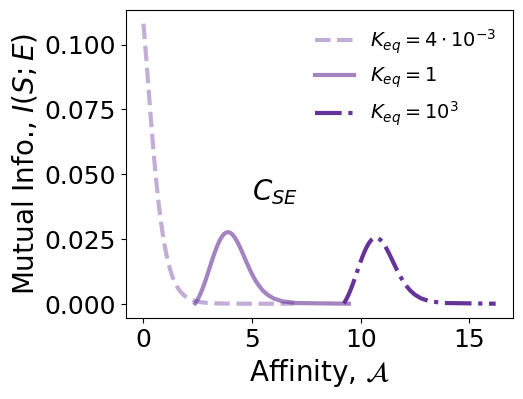

In [38]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'rebeccapurple'

ax.plot(affs[1][10], datars[1][10],color=color,
        alpha=0.4,linewidth=width, linestyle = '--', label = r'$K_{eq} = 4\cdot10^{-3}$')
ax.plot(affs[1][50], datars[1][50],color=color,
        alpha=0.6,linewidth=width, linestyle = '-', label = r'$K_{eq} = 1$')
ax.plot(affs[1][99], datars[1][99],color=color,
        alpha=1,linewidth=width, linestyle = '-.', label = r'$K_{eq} = 10^3$')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;E)$', fontsize=20)

ax.text(5,0.04,r'$C_{SE}$',fontsize=20)

#plt.savefig('Regulatory info.png',bbox_inches='tight')
#plt.savefig('Regulatory info.pdf', bbox_inches='tight')

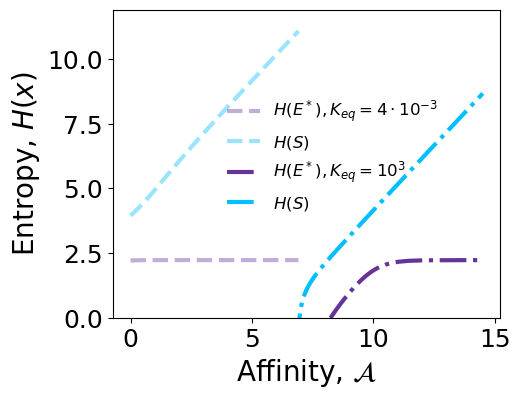

In [125]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'rebeccapurple'

ax.plot(affs[0][10], entE[0][10],color=color,
        alpha=0.4,linewidth=width, linestyle = '--', label = r'$H(E^*), K_{eq} =  4\cdot10^{-3}$')
ax.plot(affs[0][10], entS[0][10],color='deepskyblue',
        alpha=0.4,linewidth=width, linestyle = '--', label = r'$H(S)$')

#ax.plot(affs[1][10], entE[1][10],color=color,
#        alpha=0.6,linewidth=width, linestyle = '-', label = r'$H(E^*), K_{eq} =  1$')
#ax.plot(affs[1][10], entS[1][10],color='deepskyblue',
#        alpha=0.6,linewidth=width, linestyle = '-', label = r'$H(S)$')

ax.plot(affs[0][99], entE[0][99],color=color,
        alpha=1,linewidth=width, linestyle = '-.', label = r'$H(E^*), K_{eq} =  10^3$')
ax.plot(affs[0][99], entS[0][99],color='deepskyblue',
        alpha=1,linewidth=width, linestyle = '-.', label = r'$H(S)$')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc=(0.276,0.32), fontsize=12)

plt.locator_params(axis='both', nbins=5)
ax.set_ylim(0,)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Entropy, $H(x)$', fontsize=20)

plt.savefig('reg entropies.png',bbox_inches='tight')
plt.savefig('reg entropies.pdf', bbox_inches='tight')

In [91]:
Cse_k01 = []
Cse_k1 = []
Cse_k100 = []

Csp_k01 = []
Csp_k1 = []
Csp_k100 = []

for i in range(0,n):
    Cse_k01.append(max(datars[0][i][1:]))
    Cse_k1.append(max(datars[1][i][1:]))
    Cse_k100.append(max(datars[2][i][1:]))
    
    Csp_k01.append(max(datas[0][i][1:]))
    Csp_k1.append(max(datas[1][i][1:]))
    Csp_k100.append(max(datas[2][i][1:]))

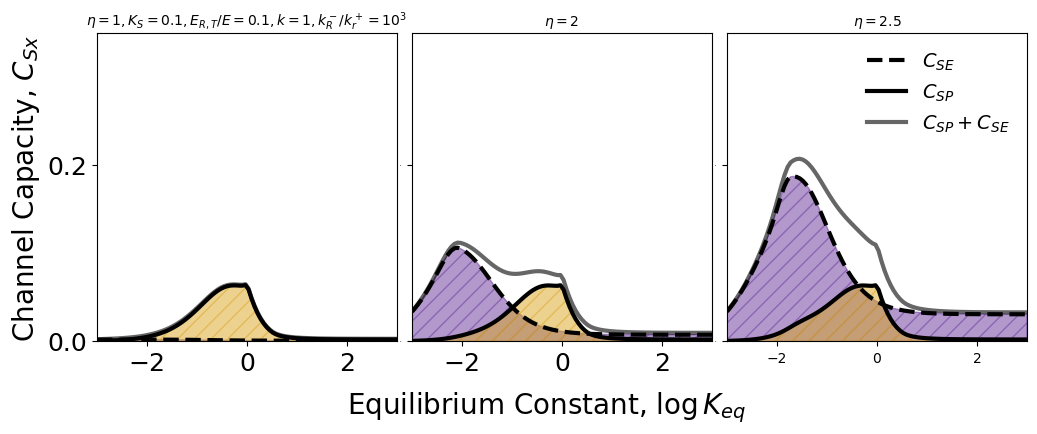

In [94]:
fig,ax = plt.subplots(1,3, figsize=(12,4))

ax = ax.flatten()

width = 3
color = 'k'

K = np.logspace(-3,3,n)

ax[0].plot(np.log10(K), Cse_k01,color=color,
        alpha=1,linewidth=width, linestyle = '--', label = r'$C_{SE}$')
ax[0].plot(np.log10(K), Csp_k01,color=color,
        alpha=1,linewidth=width, linestyle = '-', label = r'$C_{SP}$')
ax[0].plot(np.log10(K), [sum(x) for x in zip(Cse_k01, Csp_k01)],color=color,
        alpha=0.6,linewidth=width, linestyle = '-')

ax[0].fill_between(
        x= np.log10(K), 
        y1= Cse_k01,
        color= "rebeccapurple",
        hatch = '//',
        alpha= 0.5)


ax[0].fill_between(
        x= np.log10(K), 
        y1= Csp_k01,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)


ax[1].plot(np.log10(K), Cse_k1,color=color,
        alpha=1,linewidth=width, linestyle = '--', label = r'$C_{SE}$')
ax[1].plot(np.log10(K), Csp_k1,color=color,
        alpha=1,linewidth=width, linestyle = '-', label = r'$C_{SP}$')
ax[1].plot(np.log10(K), [sum(x) for x in zip(Cse_k1, Csp_k1)],color=color,
        alpha=0.6,linewidth=width, linestyle = '-', label = r'$C_{SP}+C_{SE}$')

ax[1].fill_between(
        x= np.log10(K), 
        y1= Cse_k1,
        color= "rebeccapurple",
        hatch = '//',
        alpha= 0.5)


ax[1].fill_between(
        x= np.log10(K), 
        y1= Csp_k1,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

ax[2].plot(np.log10(K), Cse_k100,color=color,
        alpha=1,linewidth=width, linestyle = '--', label = r'$C_{SE}$')
ax[2].plot(np.log10(K), Csp_k100,color=color,
        alpha=1,linewidth=width, linestyle = '-', label = r'$C_{SP}$')
ax[2].plot(np.log10(K), [sum(x) for x in zip(Cse_k100, Csp_k100)],color=color,
        alpha=0.6,linewidth=width, linestyle = '-', label = r'$C_{SP}+C_{SE}$')

ax[2].fill_between(
        x= np.log10(K), 
        y1= Cse_k100,
        color= "rebeccapurple",
        hatch = '//',
        alpha= 0.5)


ax[2].fill_between(
        x= np.log10(K), 
        y1= Csp_k100,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

ax[0].tick_params(axis='both', labelsize=18)
ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=0)
ax[2].tick_params(axis='y', labelsize=0)
ax[2].tick_params(axis='x', labelsize=18)

ax[2].legend(frameon=False, loc='best', fontsize=14)

ax[0].locator_params(axis='both', nbins=3)
ax[1].locator_params(axis='both', nbins=3)
ax[2].locator_params(axis='both', nbins=3)

ax[0].set_xlim(-3,3)
ax[0].set_ylim(0,0.35)
ax[1].set_xlim(-3,3)
ax[1].set_ylim(0,0.35)
ax[2].set_xlim(-3,3)
ax[2].set_ylim(0,0.35)

ax[0].set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

#Change the line below as required to reflect actual parameter values

ax[0].set_title(r'$\eta = 1,K_S=0.1, E_{R,T}/E=0.1, k =1, k_R^-/k_r^+=10^3$', fontsize=10) 
ax[1].set_title(r'$\eta = 2$', fontsize=10)
ax[2].set_title(r'$\eta=2.5$', fontsize=10)

plt.subplots_adjust(wspace=0.05)
plt.suptitle(r'Equilibrium Constant, $\log{K_{eq}}$', y= -0.01, fontsize=20)

plt.savefig('sensitivity 3.png',bbox_inches='tight')
plt.savefig('sensitivity 3.pdf', bbox_inches='tight')

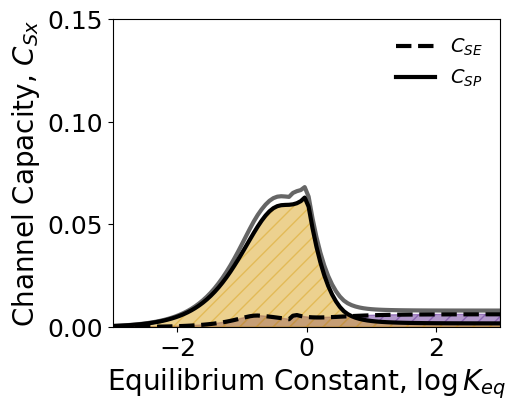

In [66]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

width = 3
color = 'k'

K = np.logspace(-3,3,n)

ax.plot(np.log10(K), Cse_k01,color=color,
        alpha=1,linewidth=width, linestyle = '--', label = r'$C_{SE}$')
ax.plot(np.log10(K), Csp_k01,color=color,
        alpha=1,linewidth=width, linestyle = '-', label = r'$C_{SP}$')
ax.plot(np.log10(K), [sum(x) for x in zip(Cse_k01, Csp_k01)],color=color,
        alpha=0.6,linewidth=width, linestyle = '-')

ax.fill_between(
        x= np.log10(K), 
        y1= Cse_k01,
        color= "rebeccapurple",
        hatch = '//',
        alpha= 0.5)


ax.fill_between(
        x= np.log10(K), 
        y1= Csp_k01,
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

ax.locator_params(axis='both', nbins=3)

ax.set_xlim(-3,3)
ax.set_ylim(0,0.15)

#ax.set_xlabel(r'Equilibrium Constant, $\log{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

ax.set_xlabel(r'Equilibrium Constant, $\log{K_{eq}}$', fontsize=20)

plt.savefig('Reg envelope bad.png',bbox_inches='tight')
plt.savefig('Reg envelope bad.pdf', bbox_inches='tight')

We expect $k$ to be around 1, or higher for reactions with low $K_{eq}$ because high downstream turnover can reduce the accumulation of $S$.

In [671]:
n = 100

BOPs = np.zeros((n,n),dtype=float)

kvals = np.logspace(-1,1,n) #downstream turnover
kregs = np.logspace(-3,3,n) #regulatory constant

Et = 0.1
Ks = 0.1
m = 2

Keqs = np.logspace(-3,3,100)

for i in range(0,n):
    for j in range(0,n):
        entropyS, entropyE, data_a, data, data_reg = calc_reg_system(kvals[i], n, 1, kregs[j], Et, Ks, m)
        
        Cse = []
        
        for k in range(0,n):
             Cse.append(max(data_reg[k][1:]))
            
        BOPs[i][j] = Keqs[np.where(Cse == max(Cse))[0]]

C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:28: RuntimeWarning: invalid value encountered in sqrt
  corr = C[1]/(np.sqrt(C[0]*C[4]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:29: RuntimeWarning: invalid value encountered in sqrt
  corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:31: RuntimeWarning: invalid value encountered in log
  entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\3992139933.py:7: RuntimeWarning: invalid value encountered in scalar divide
  mass_act = (P/S)/Keq
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:28: RuntimeWarning: invalid value encountered in scalar divide
  corr = C[1]/(np.sqrt(C[0]*C[4]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:29: RuntimeWarning: invalid value encountered in scalar divide
  corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2

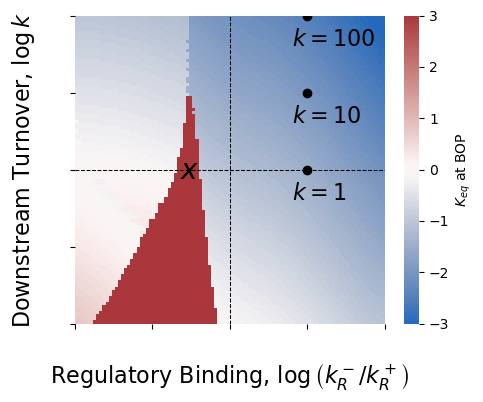

In [776]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

ax=sns.heatmap(np.log10(BOPs),vmin=-3, vmax=3, xticklabels=np.round(np.log10(kregs),0), 
               yticklabels=np.round(np.log10(kvals),0), cmap='vlag', cbar_kws={'label': r'$K_{eq}$ at BOP'})
ax.invert_yaxis()

ax.tick_params(axis='both', labelsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax.axhline(50,linewidth=0.75, color='k', linestyle='--')
ax.axvline(50,linewidth=0.75, color='k', linestyle='--')

ax.text(70,40,r'$k=1$',fontsize=16)
ax.text(70,65,r'$k=10$',fontsize=16)
ax.text(70,90,r'$k=100$',fontsize=16)

ax.scatter([75,75,75],[50, 75, 100], color='k')

ax.text(34,47,r'$x$',fontsize=20)

ax.set_xlabel(r'Regulatory Binding, $\log{\left(k_R^-/k_R^+\right)}$', fontsize=16, labelpad = 20)
ax.set_ylabel(r'Downstream Turnover, $\log{k}$', fontsize=16, labelpad=20)

plt.savefig('sensitivity.png', bbox_inches='tight')
plt.savefig('sensitivity.pdf', bbox_inches='tight')

In [826]:
n = 100

caps = []

kvals = np.logspace(-1,1,n) #downstream turnover
kregs = np.logspace(-6,6,n) #regulatory constant

Et = 0.1
Ks = 1
m = 2

Keqs = np.logspace(-3,3,100)

for i in range(0,n):
    entropyS, entropyE, data_a, data, data_reg = calc_reg_system(1, n, 1, kregs[i], Et, Ks, m)
        
    Cse = []
        
    for k in range(0,n):
        Cse.append(max(data_reg[k][1:]))
            
    caps.append(max(Cse))

C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:28: RuntimeWarning: invalid value encountered in sqrt
  corr = C[1]/(np.sqrt(C[0]*C[4]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:29: RuntimeWarning: invalid value encountered in sqrt
  corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:31: RuntimeWarning: invalid value encountered in log
  entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\3992139933.py:7: RuntimeWarning: invalid value encountered in scalar divide
  mass_act = (P/S)/Keq
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:28: RuntimeWarning: invalid value encountered in scalar divide
  corr = C[1]/(np.sqrt(C[0]*C[4]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2794050946.py:29: RuntimeWarning: invalid value encountered in scalar divide
  corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
C:\Users\euler\AppData\Local\Temp\ipykernel_16620\2

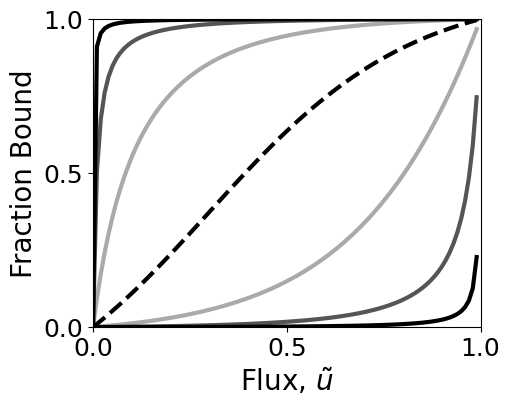

In [107]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

width = 3
color = 'k'

u = np.linspace(0,0.99,100)

for sens in [10**(-3), 10**(-2), 10**(-1), 1, 10**1, 10**2, 10**3]:
    
    Keq = 1
    bound = u/(1-u)*(1+u*(u+1/Keq))/(u/(1-u)*(1+u*(u+1/Keq))+sens)
    
    if sens == 1:
        plt.plot(u, bound, color = 'k', linewidth=width, linestyle='--')
    else:
        plt.plot(u, bound, color = 'k', linewidth=width, linestyle='-', alpha = abs(np.log10(sens))/3)

ax.tick_params(axis='both', labelsize=18)

ax.locator_params(axis='both', nbins=3)

ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.set_xlabel(r'Equilibrium Constant, $\log{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Fraction Bound', fontsize=20)

ax.set_xlabel(r'Flux, $\tilde{u}$', fontsize=20)

plt.savefig('binding curves.png',bbox_inches='tight')
plt.savefig('binding curves.pdf', bbox_inches='tight')

Text(0, 0.5, 'Channel Capacity, $C_{SE}$')

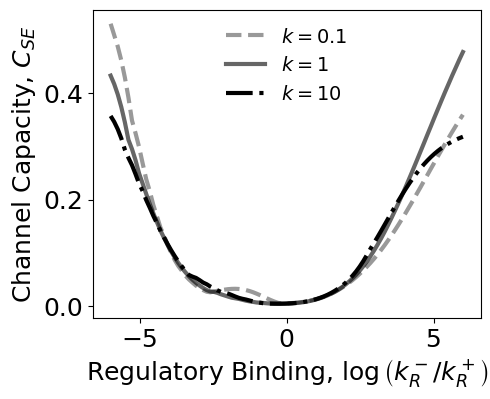

In [920]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'k'

ax.plot(np.log10(kregs), caps01,color=color,
        alpha=0.4,linewidth=width, linestyle = '--', label = r'$k=0.1$')
ax.plot(np.log10(kregs), caps,color=color,
        alpha=0.6,linewidth=width, linestyle = '-', label = r'$k=1$')
ax.plot(np.log10(kregs), caps10,color=color,
        alpha=1,linewidth=width, linestyle = '-.', label = r'$k=10$')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=3) 
#ax.set_xlim(-6,6)
#ax.set_ylim(0,0.125)

ax.set_xlabel(r'Regulatory Binding, $\log{\left(k_R^-/k_R^+\right)}$', fontsize=18)
ax.set_ylabel(r'Channel Capacity, $C_{SE}$', fontsize=18)

#plt.savefig('binding sensitivity.png',bbox_inches='tight')
#plt.savefig('binding sensitivity.pdf', bbox_inches='tight')

## C. Genome-wide structural analysis
In this section, -omics and thermodynamic data are used to correlate the role of metabolites as regulators with the thermodynamics of the reactions in which they are involved.

### C.1 Genome-scale analysis
All regulators are parsed from the BRENDA database, then assigned to reactions using genome-scale metabolic models. Thermodynamic parameters are assigned to reactions, and the correlation between regulatory status and reaction reversibility is determined. This analysis is performed for E. coli, B. bacillus, P. putida, S. cerevisiae, M. musculus, and H. sapiens.

In [1]:
#Reads in downloaded BRENDA database and splits it into individual entries, with modification of first entry to make it uniform 
#for next step

f = open('brenda_download.txt','r',encoding="utf8")
page=f.read()
f.close()

BRENDA = page.split('///')
BRENDA[0]='\n'+BRENDA[0]

FileNotFoundError: [Errno 2] No such file or directory: 'brenda_download.txt'

In [ ]:
#Breaks each BRENDA entry into relevant sub-entries and parses them based on their string structures. Takes a long time to run

data = pd.DataFrame()

for test in BRENDA:
    
    #EC number
    EC = test.split('\n')[1][3:]
    
    if 'transferred' in EC or 'deleted' in EC:       #Excludes old, duplicate, or otherwise erroneous entries   
        continue
    elif '(' in EC:
        EC = EC[0:EC.index('(')-1]
    else:
        print(EC) #To track progress
            
        #Recommended name for cross-referencing with GSMMs
        rec_name = [x for x in test.split('\n') if 'RN\t' in x][0].split('\t')[1]

        #Each entry has a unique set of serial numbers for organisms it contains. This creates a dictionary to assign entries
        #to specific organisms 
        
        organisms = [x for x in test.split('\n') if 'PR\t' in x]
        orgs = {}

        for org in organisms:
            temp = org.split(' ')[0]
            key = temp.split(' ')[0][temp.index('#')+1:-1]
            entry = org.split(' ')[1] + ' ' + org.split(' ')[2]
            orgs.update({key:entry})

        #KI values are indicated with the two-letter code KI.  
        KI = [x for x in test.split('\n') if 'KI\t' in x]
    
        #Gets all KI values and links them to organisms and inhibitors
        temp1 = []
        compounds_with_KIs = [] 

        for parameter in KI:
            if 'mutant' in parameter:     #Excludes mutated enzymes, since we are interested in native metabolism
                continue
            else:
                if '}' not in parameter:   #Excludes some (not all) synthetic effectors
                    continue
                elif '}' in parameter.split('{')[1]:    #Curly braces indicate the name of the effector compound 
                    compound = parameter.split('{')[1][0:parameter.split('{')[1].index('}')]
                else:
                    compound = parameter.split('{')[1]    #Some close braces are not in-line 
            
                if compound=='more':    #'More' indicates more literature entries, not more compounds
                    continue
                else:    
                    organism = parameter.split(' ')[0][parameter.split(' ')[0].index('#')+1:-1]
                    #Each entry may have several organisms associated with it
                    
                for org in organism.split(','):                
                    value = parameter.split(' ')[1]
                    
                    if value == '-999':    #This is a placeholder for more complex entries 
                        continue
                    elif 'e' in value:     #To handle entries in scientific notation
                        new_value = float(value.split('e')[0])*10**(float(value.split('e')[1]))
                        if [org, value, compound] not in temp1:
                            temp1.append([org, new_value, compound])
                            compounds_with_KIs.append(compound)
                        else:
                            continue    
                    elif '-' in value:     #some KI values are provided as ranges
                        new_value = 0.5*(float(value.split('-')[0]) + float(value.split('-')[1]))  #Take average of these ranges
                        if [org, value, compound] not in temp1:
                            temp1.append([org, new_value, compound])
                            compounds_with_KIs.append(compound)    #This list will help assigning KI values below
                        else:
                            continue                 
                    
                    else:    
                        value = float(value)
                        if [org, value, compound] not in temp1:
                            temp1.append([org, value, compound])
                            compounds_with_KIs.append(compound)
                        else:
                            continue
    
        #Gets inhibitors. IN is the two-letter code for each inhibitor.
    
        inhibitors = [x for x in test.split('\n') if 'IN\t' in x]

        for inh in inhibitors:
            
            if len(inh.split(' ')) <= 2:    #Excludes some (not all) synthetic effectors
                continue
            elif '(#' in inh:
                regulator = inh[inh.index(' ')+1:inh.index('(')-1]
            else:
                temp = inh.split('<')[0]
                #print(temp)
                regulator = temp[temp.index(' ')+1:-1]
            
            
            #elif '[' in inh:     #Excludes some other synthetic effectors 
                #continue
            #elif '(' in inh:
                #regulator = inh[inh.index(' ')+1:inh.index('(')-1]
            #elif inh.split(' ')[2].lower() == 'acid':    #Splitting string by spaces cuts out acids, so add these back in 
                #regulator = inh.split(' ')[1]+inh.split(' ')[2]
            #else:    
                #regulator = inh.split(' ')[1]
        
            if regulator == 'more':   #See note about 'more' above
                continue
            
            elif regulator in compounds_with_KIs:    #Now assign existing KI values to their respective inhibitors 
                organism = inh.split(' ')[0][inh.split(' ')[0].index('#')+1:-1].split(',')
            
                for org in organism:
                    for entry in temp1:
                        if org == entry[0] and regulator == entry[2]:
                            if org in orgs.keys():
                                data = data.append({'EC':EC,'enzyme':rec_name,'organism':orgs[org],'regulator':regulator,
                                                    'type':'inhibition','KI':entry[1]}, ignore_index=True)
                            else:
                                continue
   
            else:    
                organism = inh.split(' ')[0][inh.split(' ')[0].index('#')+1:-1].split(',')
    
                for org in organism:
                    if org in orgs.keys():
                        data = data.append({'EC':EC,'enzyme':rec_name,'organism':orgs[org],'regulator':regulator,
                                            'type':'inhibition','KI':NaN}, ignore_index=True)
                    else:
                        continue
    
    
        #Gets activators. This code is the same as above, but KA values are not included in BRENDA, so this part is excluded
    
        activators = [x for x in test.split('\n') if 'AC\t' in x]

        for act in activators:
            
            if len(act.split(' ')) <= 2:
                continue
            elif '(#' in act:
                regulator = act[act.index(' ')+1:act.index('(')-1]
            else:
                temp = act.split('<')[0]
                regulator = temp[temp.index(' ')+1:-1]
            
            
            #elif '[' in act:
                #continue
            #elif '(' in act:
                #regulator = act[act.index(' ')+1:act.index('(')-1]
            #elif act.split(' ')[2].lower() == 'acid':
                #regulator = act.split(' ')[1]+act.split(' ')[2]
            #else:    
                #regulator = act.split(' ')[1]
        
            if regulator == 'more':
                continue
            
            else:    
                organism = act.split(' ')[0][act.split(' ')[0].index('#')+1:-1].split(',')
    
            for org in organism:
                if org in orgs.keys():
                    data = data.append({'EC':EC,'enzyme':rec_name,'organism':orgs[org],'regulator':regulator,
                                        'type':'activation','KI':NaN}, ignore_index=True) 
                else:
                    continue
data = data.replace(NaN,0)

There are no naming conventions for metabolites in BRENDA, which poses a challenge to associating metabolites with reactions in a genome-scale metabolic model. Such associations must be made in order to assign constraining thermodynamic parameter values to metabolites. 

To solve this problem, the metabolite names are translated to KEGG IDs using a dictionary. A .txt file is including in the repository associated with this project to enable translation.

In [ ]:
#Open file with kegg IDs

f = open('output_kegg_compounds.txt','r',encoding="utf8")
page=f.read()
f.close()

lines = page.split('\n')
temp = [x.split('\t') for x in lines][:-1]
thesaurus = {}

#Create a dictionary which assigns chemical name synonyms to KEGG IDs
for entry in temp:
    kegg_id = entry[0].lower()
    synonyms = entry[1].split(';')
        
    for word in synonyms:
        thesaurus.update({word.lower():kegg_id})
        
        if word[0:2] == 'D-':
            thesaurus.update({word[2:].lower():kegg_id})
        
kegg_ids = []

#Get KEGG IDs for compounds which have them in the BRENDA data

for index,row in data.iterrows():
    if row['regulator'].lower() in thesaurus.keys():
        kegg_ids.append(thesaurus[row['regulator'].lower()])
    else:
        kegg_ids.append('none')

#Assign KEGG IDs to compounds in BRENDA data        
data['kegg_id'] = kegg_ids        

In [ ]:
data.to_excel('brenda_regulators.xlsx')

This is a breakpoint: the code below may be run provided the pre-parsed BRENDA data, in the form of an .xlsx file, is available.

In [ ]:
data = pd.read_excel('brenda_regulators.xlsx')

In the next blocks of code, BRENDA data for organisms with at least 1000 entries are used in conjuction with genome-scale metabolic models to find constraining thermodynamic parameter values, and average downstream thermodynamic parameter values, for each metabolite. Then, statistical analysis and visualization is performed to show that, indeed, regulators are much more often found upstream of reactions with low $K_{eq}$. 

In [ ]:
ecoli = data[data['organism'] == 'Escherichia coli']
yeast = data[data['organism'] == 'Saccharomyces cerevisiae']
mouse = data[data['organism'] == 'Mus musculus']
pseudomonas = data[data['organism'] == 'Pseudomonas putida']
bacillus = data[data['organism'] == 'Bacillus subtilis']
human = data[data['organism'] == 'Homo sapiens']

# GEMs

ec_model = cameo.models.bigg.iML1515 # E coli
sc_model = cameo.models.bigg.iMM904 # Saccharomyces cerevisiae
mm_model = cameo.models.bigg.iMM1415 # Mus musculus
pp_model = cameo.models.bigg.iJN1463 # Pseudomonas putida
bs_model = cameo.models.bigg.iYO844 # Bacillus subtilis
hs_model = cameo.models.bigg.RECON1 # Homo sapiens

In [ ]:
# Open GEM source file and parse to get species to convert to KEGG and/or MetaNetX IDs. This is important for consistency with
# both BRENDA data and the eQuilibrator framework

def parse_metabolites(GEM_string):

    f = open(GEM_string, "r")
    page = f.read()
    f.close()

    page = page.split('\n')
    page = page[page.index('    <listOfSpecies>'):page.index('    </listOfSpecies>')]
    page = page[1:]

    # Create dictionaries for metabolites that are actually in the model that contains their IDs

    kegg_ids = {}
    metanetx_ids = {}

    for entry in page:
        if '      <species id=' in entry:
            CompAbr = entry[entry.index('_')+1:entry.index(' c')][0:-3]
        if '                  <rdf:li rdf:resource="http://identifiers.org/kegg.compound/' in entry:
            KEGG_ID = entry[entry.index('C'):entry.index('>')-2]
            kegg_ids[CompAbr] = KEGG_ID
        if '                  <rdf:li rdf:resource="http://identifiers.org/metanetx.chemical/' in entry:
            meta_ID = entry[entry.index('M'):entry.index('>')-2]
            metanetx_ids[CompAbr] = meta_ID
    
    return kegg_ids, metanetx_ids

# Build a dictionary of reactions that the eQuilibrator API can understand.

def translate_reactions(GEM_model, kegg_ids, metanetx_ids):
    rxns = {}

    for reaction in GEM_model.reactions:
        rxn = str(reaction)

        rxn_name = rxn[0:rxn.index(':')]

        temp = [] 

        for entry in rxn.split(' ')[1:]:
            if entry == '+':
                temp.append(entry)
            elif entry == '-->':
                temp.append('=')
            elif entry == '<=>':
                temp.append('=')
            elif entry[0:-2] in kegg_ids:
                temp.append('kegg:'+kegg_ids[entry[0:-2]])
            elif entry[0:-2] in metanetx_ids:
                temp.append('metanetx.chemical:'+metanetx_ids[entry[0:-2]])
            else:
                temp.append(entry)


        rxns[rxn_name] = ' '.join(temp)
    
    return rxns

# Now get thermodynamic information

def get_thermo(reaction_dict):
    
    threshold = 10**4*Q_('kilojoule / mole') # Set an error threshold to exclude some values

    thermo = {}
    thermo_err = {}

    for reaction in reaction_dict:
        try:
            temp = cc.parse_reaction_formula(reaction_dict[reaction])
        except:
            continue
        if not temp.is_balanced():
            continue
        else:
            try:
                dG = cc.standard_dg(temp)
            except:
                continue
            else:
                if dG.error > threshold:
                    continue
                else:
                    thermo[reaction] = float(dG.value/Q_('kilojoule / mole'))
                    thermo_err[reaction] = float(dG.error/Q_('kilojoule / mole'))
    
    return thermo, thermo_err

def find_maxes(metabs, thermo, reactions, brenda):
    
    max_Gs = []

    for metabolite in metabs.values(): # For all regulators, find all consuming reactions

        delG = []

        for reaction in thermo:
            if reaction[-2:] == 'pp' or reaction[-2:] == 'ex' or reaction[-1] == 'm':
                continue
            else:
                reactants = reactions[reaction].split(' = ')[0]
                reactants = [x[x.index(':')+1:].lower() for x in reactants.split(' + ') if x != ' + ']

                if metabolite.lower() in reactants:
                    if len(set(brenda['kegg_id']).intersection(set(reactants))) >= 1:
                        delG.append((reaction, thermo[reaction], 'reg'))
                    else:
                        delG.append((reaction, thermo[reaction], 'nonreg'))
                else:
                    continue

        if len(delG) == 0:
            continue
        else:
            temp = [x for x in delG if x[1] == max([x[1] for x in delG])][0]

            if temp in max_Gs:
                continue
            else:
                max_Gs.append(temp)
    return max_Gs

def find_geos(metabs, thermo, reactions, brenda):
    
    geo_Gs = []

    for metabolite in metabs.values(): # For all regulators, find all consuming reactions

        delG = []

        for reaction in thermo:
            if reaction[-2:] == 'pp' or reaction[-2:] == 'ex' or reaction[-1] == 'm':
                continue
            else:
                reactants = reactions[reaction].split(' = ')[0]
                reactants = [x[x.index(':')+1:].lower() for x in reactants.split(' + ') if x != ' + ']

                if metabolite.lower() in reactants:
                    if len(set(brenda['kegg_id']).intersection(set(reactants))) >= 1:
                        delG.append((reaction, thermo[reaction], 'reg'))
                    else:
                        delG.append((reaction, thermo[reaction], 'nonreg'))
                else:
                    continue

        if len(delG) == 0:
            continue
        #elif len([x[1] for x in delG if x[2] == 'reg']) == 0 or len([x[1] for x in delG if x[2] == 'nonreg']) == 0:
         #   continue
        else:
            temp_r = (scipy.stats.gmean([np.exp(-x[1]*1000/(8.314*298)) for x in delG if x[2] == 'reg']), 'reg')
            temp_nr = (scipy.stats.gmean([np.exp(-x[1]*1000/(8.314*298)) for x in delG if x[2] == 'nonreg']), 'nonreg')

            if temp_r in geo_Gs or temp_nr in geo_Gs:
                continue
            else:
                geo_Gs.append(temp_r)
                geo_Gs.append(temp_nr)
    return geo_Gs

def find_Gs(metabs, thermo, reactions, brenda):
        
    Gs_reg = []
    Gs_nonreg = []
        
    for metabolite in metabs.values():
            
        for reaction in thermo:
            if reaction[-2:] == 'pp' or reaction[-2:] == 'ex' or reaction[-1] == 'm':
                continue
            else:
                reactants = reactions[reaction].split(' = ')[0]
                reactants = [x[x.index(':')+1:].lower() for x in reactants.split(' + ') if x != ' + ']

                if metabolite.lower() in reactants:
                    if len(set(brenda['kegg_id']).intersection(set(reactants))) >= 1:
                        if thermo[reaction] in Gs_reg:
                            continue
                        else:
                            Gs_reg.append(thermo[reaction])
                    else:
                        if thermo[reaction] in Gs_nonreg:
                            continue
                        else:
                            Gs_nonreg.append(thermo[reaction])
                else:
                    continue
    
    return Gs_reg, Gs_nonreg

In [ ]:
ec_metabsk, ec_metabsmx = parse_metabolites('iML1515.xml')
ec_reactions = translate_reactions(ec_model, ec_metabsk, ec_metabsmx)
ec_thermo, ec_thermo_err = get_thermo(ec_reactions)
ec_max_Gs = find_maxes(ec_metabsk, ec_thermo, ec_reactions, ecoli)
ec_Gsr, ec_Gsnr = find_Gs(ec_metabsk, ec_thermo, ec_reactions, ecoli)
ec_geos = find_geos(ec_metabsk, ec_thermo, ec_reactions, ecoli)

sc_metabsk, sc_metabsmx = parse_metabolites('iMM904.xml')
sc_reactions = translate_reactions(sc_model, sc_metabsk, sc_metabsmx)
sc_thermo, sc_thermo_err = get_thermo(sc_reactions)
sc_max_Gs = find_maxes(sc_metabsk, sc_thermo, sc_reactions, yeast)
sc_Gsr, sc_Gsnr = find_Gs(sc_metabsk, sc_thermo, sc_reactions, yeast)
sc_geos = find_geos(sc_metabsk, sc_thermo, sc_reactions, yeast)

mm_metabsk, mm_metabsmx = parse_metabolites('iMM1415.xml')
mm_reactions = translate_reactions(mm_model, mm_metabsk, mm_metabsmx)
mm_thermo, mm_thermo_err = get_thermo(mm_reactions)
mm_max_Gs = find_maxes(mm_metabsk, mm_thermo, mm_reactions, mouse)
mm_Gsr, mm_Gsnr = find_Gs(mm_metabsk, mm_thermo, mm_reactions, mouse)
mm_geos = find_geos(mm_metabsk, mm_thermo, mm_reactions, mouse)

pp_metabsk, pp_metabsmx = parse_metabolites('iJN1463.xml')
pp_reactions = translate_reactions(pp_model, pp_metabsk, pp_metabsmx)
pp_thermo, pp_thermo_err = get_thermo(pp_reactions)
pp_max_Gs = find_maxes(pp_metabsk, pp_thermo, pp_reactions, pseudomonas)
pp_Gsr, pp_Gsnr = find_Gs(pp_metabsk, pp_thermo, pp_reactions, pseudomonas)
pp_geos = find_geos(pp_metabsk, pp_thermo, pp_reactions, pseudomonas)

bs_metabsk, bs_metabsmx = parse_metabolites('iYO844.xml')
bs_reactions = translate_reactions(bs_model, bs_metabsk, bs_metabsmx)
bs_thermo, bs_thermo_err = get_thermo(bs_reactions)
bs_max_Gs = find_maxes(bs_metabsk, bs_thermo, bs_reactions, bacillus)
bs_Gsr, bs_Gsnr = find_Gs(bs_metabsk, bs_thermo, bs_reactions, bacillus)
bs_geos = find_geos(bs_metabsk, bs_thermo, bs_reactions, bacillus)

hs_metabsk, hs_metabsmx = parse_metabolites('Recon3D.xml')
hs_reactions = translate_reactions(hs_model, hs_metabsk, hs_metabsmx)
hs_thermo, hs_thermo_err = get_thermo(hs_reactions)
hs_max_Gs = find_maxes(hs_metabsk, hs_thermo, hs_reactions, human)
hs_Gsr, hs_Gsnr = find_Gs(hs_metabsk, hs_thermo, hs_reactions, human)
hs_geos = find_geos(hs_metabsk, hs_thermo, hs_reactions, human)


In [ ]:
ec_maxes = pd.DataFrame([(*x, 'E. coli') for x in ec_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
pp_maxes = pd.DataFrame([(*x, 'P. putida') for x in pp_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
bs_maxes = pd.DataFrame([(*x, 'B. subtilis') for x in bs_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
sc_maxes = pd.DataFrame([(*x, 'S. cerevisiae') for x in sc_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
mm_maxes = pd.DataFrame([(*x, 'M. musculus') for x in mm_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
hs_maxes = pd.DataFrame([(*x, 'H. sapiens') for x in hs_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))

dfmaxes = ec_maxes.append(pp_maxes).append(bs_maxes).append(sc_maxes).append(mm_maxes).append(hs_maxes)
dfmaxes['kmin'] = np.exp(-dfmaxes['gmax']*1000/(8.314*298))
dfmaxes

In [ ]:
maxes_toplot = dfmaxes[dfmaxes['gmax'] <= 100]

In [ ]:
pvals = []

for org in ['E. coli', 'P. putida', 'B. subtilis', 'S. cerevisiae', 'M. musculus', 'H. sapiens']:
    pval = scipy.stats.mannwhitneyu(dfmaxes[(dfmaxes['organism']==org)&(dfmaxes['classification']=='reg')]['kmin'],
                                    dfmaxes[(dfmaxes['organism']==org)&(dfmaxes['classification']=='nonreg')]['kmin'],
                                   alternative='less').pvalue
    pvals.append(pval)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(9,4))

_= sns.boxplot(x = 'organism', y='kmin', hue = 'classification', data=maxes_toplot,
               ax = ax, fliersize = 1,  palette=["rebeccapurple", "goldenrod"], boxprops=dict(alpha=.7))

ax.axhline(1,linewidth=0.75,linestyle='--',color='k')
plt.yscale('log')
plt.ylim(10**(-24),10**19.7)

ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14, rotation=45)

for i in range(0,len(pvals)):
    
    ax.plot([i-0.25,i+0.25],[10**(-20),10**(-20)],color='k')
    ax.text(i-0.4, 10**(-22.5),r"$p=$"+"{:1.2e}".format(pvals[i]))

ax.set_ylabel('$K_{eq, min}$',fontsize=20)
ax.set_xlabel(None)

ax.legend(frameon=False)

#plt.savefig('Keqmin dists.png',bbox_inches='tight')
#plt.savefig('Keqmin dists.pdf',bbox_inches='tight')

In [ ]:
ec_geo = pd.DataFrame([(x[0], 'E. coli', 'reg') for x in ec_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
ec_geo = ec_geo.append(pd.DataFrame([(x[0], 'E. coli', 'nonreg') for x in ec_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

pp_geo = pd.DataFrame([(x[0], 'P. putida', 'reg') for x in pp_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
pp_geo = pp_geo.append(pd.DataFrame([(x[0], 'P. putida', 'nonreg') for x in pp_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

bs_geo = pd.DataFrame([(x[0], 'B. subtilis', 'reg') for x in bs_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
bs_geo = bs_geo.append(pd.DataFrame([(x[0], 'B. subtilis', 'nonreg') for x in bs_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

sc_geo = pd.DataFrame([(x[0], 'S. cerevisiae', 'reg') for x in sc_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
sc_geo = sc_geo.append(pd.DataFrame([(x[0], 'S. cerevisiae', 'nonreg') for x in sc_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

mm_geo = pd.DataFrame([(x[0], 'M. musculus', 'reg') for x in mm_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
mm_geo = mm_geo.append(pd.DataFrame([(x[0], 'M. musculus', 'nonreg') for x in mm_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

hs_geo = pd.DataFrame([(x[0], 'H. sapiens', 'reg') for x in hs_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
hs_geo = hs_geo.append(pd.DataFrame([(x[0], 'H. sapiens', 'nonreg') for x in hs_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

df_geo = ec_geo.append(pp_geo).append(bs_geo).append(sc_geo).append(mm_geo).append(hs_geo)
df_geo

df_geo.dropna(axis=0, inplace=True)
df_geo

In [ ]:
geo_toplot = df_geo[(df_geo['geoK'] >= 10**(-20))&(df_geo['geoK'] <= 10**19)]

In [ ]:
pvals_all = []

for org in ['E. coli', 'P. putida', 'B. subtilis', 'S. cerevisiae', 'M. musculus', 'H. sapiens']:
    pval = scipy.stats.mannwhitneyu(df_geo[(df_geo['organism']==org)&(df_geo['classification']=='reg')]['geoK'],
                                    df_geo[(df_geo['organism']==org)&(df_geo['classification']=='nonreg')]['geoK'],
                                   alternative='less').pvalue
    pvals_all.append(pval)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(9,4))

_= sns.boxplot(x = 'organism', y='geoK', hue = 'classification', data=geo_toplot,
               ax = ax, fliersize = 1,  palette=["rebeccapurple", "goldenrod"], boxprops=dict(alpha=.7))

ax.axhline(1,linewidth=0.75,linestyle='--',color='k')
plt.yscale('log')
plt.ylim(10**(-24),10**19.7)

ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14, rotation=45)

for i in range(0,len(pvals)):
    
    ax.plot([i-0.25,i+0.25],[10**(-20),10**(-20)],color='k')
    ax.text(i-0.4, 10**(-22.5),r"$p=$"+"{:1.2e}".format(pvals_all[i]))

ax.set_ylabel(r'$\bar{K}_{eq}$',fontsize=20)
ax.set_xlabel(None)

ax.legend(loc = (1,0.9),frameon=False)

#plt.savefig('Keq dists.png',bbox_inches='tight')
#plt.savefig('Keq dists.pdf',bbox_inches='tight')